### prepare packages and path setting

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import main_single
from os.path import exists
import argparse
import matplotlib.pyplot as plt
import pandas as pd
import os, fnmatch

from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import curdoc
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
# set the path
project_path = "./"
log_path = "log/single_phy_same_train_multi/toy_lgssm/"
# log_path = "multi_correct_para/toy_lgssm"
test_output_path = "/data/"

### compare z_estimate and the z_KF 
- VAE-RNN
- VAE-RNN-PHY: A+B (dynamic of A is partially known, input matrix is known)
- VAE-RNN-PHY: A+B+measurement panelty 
    - weight = 0.1
    - weight = 0.5
    - weight = 1
- VAE-RNN-PHY: B (dynamic of A is unknown)
- VAE-RNN-PHY: B+measurement panelty 
    - weight = 0.1
    - weight = 0.5
    - weight = 1

Because the lgssm dataset doesn't include any x information.

__Kalman filter is used__

Because the lgssm_5 dataset includes x information.

__we can compare Z and estimated x__ 

In [3]:
def plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, rmse, panelty,h_dim,length=50,start_from=0):
    plt.figure(figsize=(6, 2.5))
    plt.plot(range(1, length +1), x_kf_0[start_from:start_from+length], linestyle='dotted',color='orange',label='x_kf_0')
    plt.plot(range(1, length +1), x_kf_1[start_from:start_from+length], linestyle='dotted',color='blue',label='x_kf_1')
    plt.plot(range(1, length +1), x_nn_0[start_from:start_from+length], linestyle='-',color='orange',label='x_nn_0')
    plt.plot(range(1, length +1), x_nn_1[start_from:start_from+length], linestyle='-',color='blue',label='x_nn_1')

    plt.xlabel('k step')
    plt.ylabel('value')
    plt.title('rmse={}, panelty={}, h_dim={}'.format(rmse,panelty,h_dim))
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()
    
def plot_k_nn_x_y(x_kf_0,x_kf_1,x_nn_0,x_nn_1, y,length=50):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, length +1), x_kf_0[0:length], linestyle='dotted',color='orange',label='x_kf_0')
    plt.plot(range(1, length +1), x_kf_1[0:length], linestyle='dotted',color='blue',label='x_kf_1')
    plt.plot(range(1, length +1), x_nn_0[0:length], linestyle='-',color='orange',label='x_nn_0')
    plt.plot(range(1, length +1), x_nn_1[0:length], linestyle='-',color='blue',label='x_nn_1')
    plt.plot(range(1, length +1), y[0:length], linestyle='-',color='red',label='y')
    

    plt.xlabel('k step')
    plt.ylabel('value')
    # plt.title('RMSE--RNN hiden states dimension')
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()

# pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h{}_z2_n1.csv"
def read_rsme(pattern, h_dim_max):
    rmse_value = []
    for i in range(1,h_dim_max+1):
        df = pd.read_csv(pattern.format(i))
        rmse_value.append(df["rmse"].mean()) 
    return rmse_value

def read_rsme_every_5(pattern, h_dim_max ):
    rmse_value = []
    for i in range(2,h_dim_max+1):
        df = pd.read_csv(pattern.format(i*5))
        # print(i*5,df["rmse"])
        rmse_value.append(df["rmse"].mean()) 
    return rmse_value
    
def read_std(pattern, h_dim_max):
    std_value = []
    for i in range(2,h_dim_max+1):
        df = pd.read_csv(pattern.format(i))
        std_value.append(df["rmse"].std()) 
    return std_value

def read_std_every_5(pattern, h_dim_max ):
    std_value = []
    for i in range(2,h_dim_max+1):
        df = pd.read_csv(pattern.format(i*5))
        std_value.append(df["rmse"].std()) 
    return std_value

def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                print(root,name)
                result.append(os.path.join(root, name))
    return result

A = np.array([[0.7, 0.8], [0, 0.1]])
B = np.array([[-1], [0.1]])
C = np.array([[1], [0]]).transpose()
Q = np.sqrt(0.25) * np.identity(2)
R = np.sqrt(1) * np.identity(1)
sigma_state = np.sqrt(0.25)
sigma_out = np.sqrt(1)

def KF_MU(C, R, y, P, xhat):
    # Kalman filter coefficient
    S = C.dot(P).dot(np.transpose(C)) + R
    K = P.dot(np.transpose(C)) * np.linalg.inv(S)

    # estimated observations
    yhat_ = C.dot(xhat)

    # measurement residual error (innovation error)
    innov = y - yhat_

    # updated estimate of the current state
    xhat = xhat + K.dot(innov)

    # updated state covariane matrix
    P = P - K.dot(C).dot(P)
    
    # TODO: check why the residual is calculated like this
    
    # updated (filtered) output estimate y(k|k)
    yhat = C.dot(xhat)
    # print("KF_MU",yhat, "lalala",xhat, "lalala",P, K)
    return yhat, xhat, P, K


# time update of KF
def KF_TU(A, B, Q, P, xhat, u):
    # update of current state
    
    xhat = A.dot(xhat) + B.dot(u)

    # update of covariance
    P = A.dot(P).dot(np.transpose(A)) + Q

    return xhat, P

def run_kalman_filter(A, B, C, Q, R, u, y):
    # get simulation time
    k_max = u.shape[-1]
    # sizes
    # The lines `n_x = A.shape[-1]` and `n_y = C.shape[0]` are used to determine the dimensions of the
    # state vector `x` and the measurement vector `y` respectively.
    n_x = A.shape[-1]
    n_y = C.shape[0]

    # allocation
    xhat_list = np.zeros([k_max,n_x])
    yhat = np.zeros([n_y, k_max])
    xhat = np.zeros([n_x, k_max+1])

    # initialization
    P = np.dot(B, np.transpose(B))

    for k in range(k_max):
        # measurement update
        yhat[:, k], xhat[:,k+1], P, K = KF_MU(C, R, y[:,k], P, xhat[:,k])
        # time update
        xhat[:,k], P = KF_TU(A, B, Q, P, xhat[:,k], u[:,k])
        # xhat_list[k] = xhat.transpose()

    return yhat,xhat[:,0:k_max]

def run_toy_lgssm_sim(u, A, B, C, sigma_state, sigma_out):
    # get length of input
    k_max = u.shape[-1]

    # size of variables
    n_u = 1
    n_y = 1
    n_x = 2

    # allocation
    x = np.zeros([n_x, k_max + 1])
    y = np.zeros([n_y, k_max])

    # run over all time steps
    for k in range(k_max):
        # print( x[:, k])
        # print( A)
        

        x[:, k + 1] = np.dot(A, x[:, k]) + np.dot(B, u[:, k]) + sigma_state * np.random.randn(n_x)
        y[:, k] = np.dot(C, x[:, k])
    return y, x[:,0:k_max]

def x_kf_nn(pattern, rmse_path, panelty,h_dim,length = 100,start_from=0):

    # model_name = "VAE-RNN_None"
    # path = project_path+log_path+model_name+test_output_path

    df = pd.read_csv(pattern)
    df.head()

    u=df['u_test_0'].to_numpy().transpose()
    u=np.expand_dims(u, axis=0)
    y=df['y_test_0'].to_numpy().transpose()
    y=np.expand_dims(y, axis=0)

    y_kalman, x_kalman = run_kalman_filter( A, B, C, Q, R,u,y)
    # y_kalman, x_kalman = run_kalman_filter(A, B, C, Q, R, u, df["y_true_with_noise"])
    x_kf_0 = x_kalman[0]
    x_kf_1 = x_kalman[1]

    x_nn_0 = df["z_0"][:]
    x_nn_1 = df["z_1"][:]
    df_rmse = pd.read_csv(rmse_path)
    rmse = df_rmse["rmse"][0]
    print(rmse)
    vaf = df_rmse["vaf"]
    
    plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, rmse, panelty,h_dim, length,start_from)
    # run_toy_lgssm_sim
def x_sim_nn(pattern,length = 100):
    # pattern = '*.csv'
    # model_name = "VAE-RNN_None"
    # path = project_path+log_path+model_name+test_output_path

    df = pd.read_csv(pattern)
    df.head()

    u=df['u_test_0'].to_numpy()
    u=np.expand_dims(u, axis=0)
    y=df['y_test_0'].to_numpy()
    # y=np.expand_dims(y, axis=0)

    _, x_kalman = run_toy_lgssm_sim(u,A, B, C, sigma_state,sigma_out)
    # y_kalman, x_kalman = run_kalman_filter(A, B, C, Q, R, u, df["y_true_with_noise"])
    x_kf_0 = x_kalman[0]
    x_kf_1 = x_kalman[1]

    x_nn_0 = df["z_0"][:]
    x_nn_1 = df["z_1"][:]

    plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length)
    
def x_ext_nn(pattern, rmse_path, panelty,h_dim,length = 100):

    # model_name = "VAE-RNN_None"
    # path = project_path+log_path+model_name+test_output_path

    df = pd.read_csv(pattern)
    df.head()

    u=df['u_test_0'].to_numpy().transpose()
    u=np.expand_dims(u, axis=0)
    y=df['y_test_0'].to_numpy().transpose()
    y=np.expand_dims(y, axis=0)

    data_path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/data/Toy_LGSSM/toy_lgssm_pre_trainingset_0.npz"
    test_data = np.load(data_path)
    print(test_data)
    x=test_data['x_test']
    x_test_0 = x[0]
    x_test_1 = x[1]

    x_nn_0 = df["z_0"][:]
    x_nn_1 = df["z_1"][:]
    df_rmse = pd.read_csv(rmse_path)
    rmse = df_rmse["rmse"][0]
    print(rmse)
    vaf = df_rmse["vaf"]
    
    plot_k_nn_x(x_test_0,x_test_1,x_nn_0,x_nn_1, rmse, panelty,h_dim, length)


1.5889616012573242


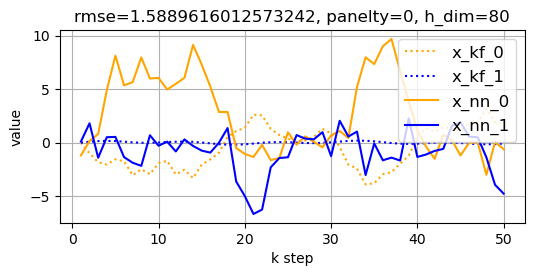

In [4]:

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm_5_pre/VAE-RNN_None/toy_lgssm_5_pre_h80_z2_n1_A0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm_5_pre/VAE-RNN_None/data/toy_lgssm_5_pre_h80_z2_n1_A0.csv"
x_kf_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 50)


1.5889616012573242


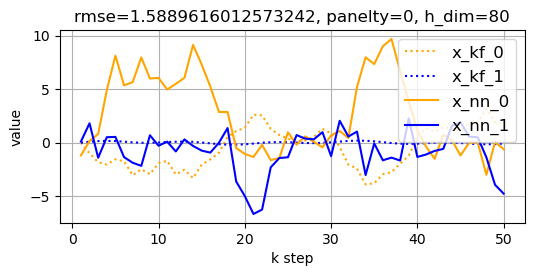

In [18]:

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm_5_pre/VAE-RNN_None/toy_lgssm_5_pre_h80_z2_n1_A0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm_5_pre/VAE-RNN_None/data/toy_lgssm_5_pre_h80_z2_n1_A0.csv"
x_kf_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 50)


1.849101844299364


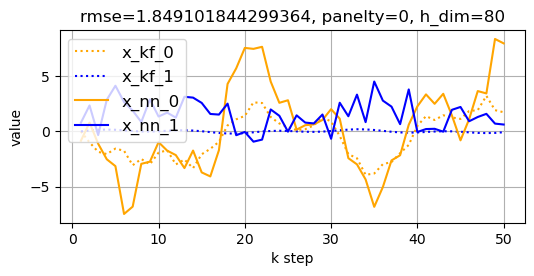

1.849101844299364


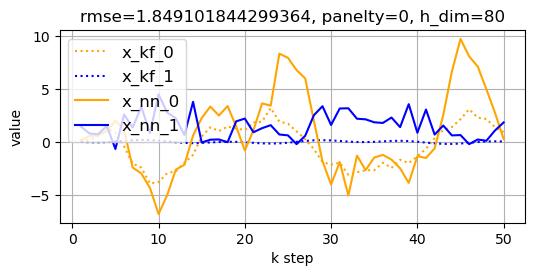

1.849101844299364


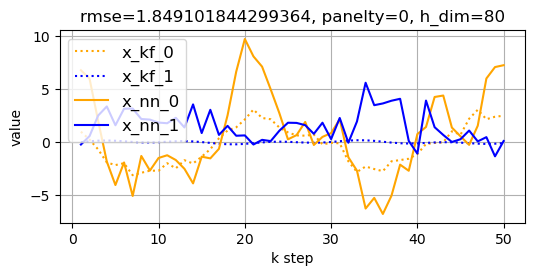

1.849101844299364


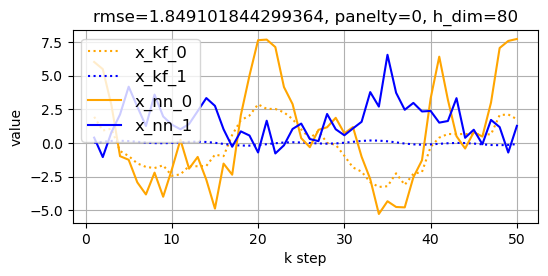

1.8738634594057195


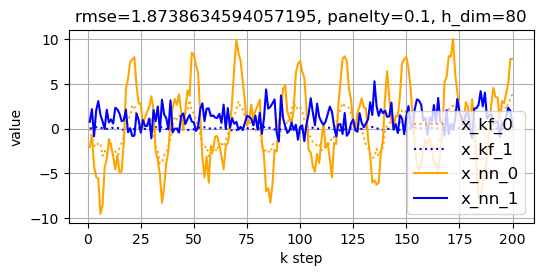

1.8548072404961096


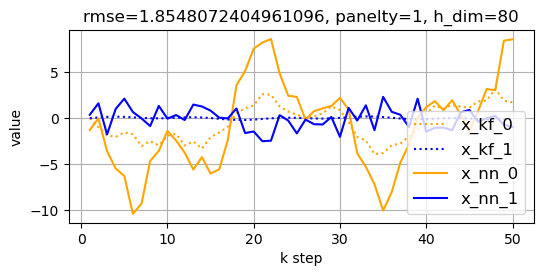

In [16]:
pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/toy_lgssm_h80_z2_n1_mpw0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/data/toy_lgssm_h80_z2_n1_mpw0.csv"

x_kf_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 50,start_from=0)
x_kf_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 50,start_from=25)
x_kf_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 50,start_from=50)
x_kf_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 50,start_from=100)

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/toy_lgssm_h80_z2_n1_mpw1_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/data/toy_lgssm_h80_z2_n1_mpw1.csv"
x_kf_nn(pattern, rmse_path, panelty=0.1,h_dim=80,length = 200)

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/toy_lgssm_h80_z2_n1_mpw10_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/data/toy_lgssm_h80_z2_n1_mpw10.csv"
x_kf_nn(pattern, rmse_path, panelty=1,h_dim=80,length = 50)


1.865797719622044


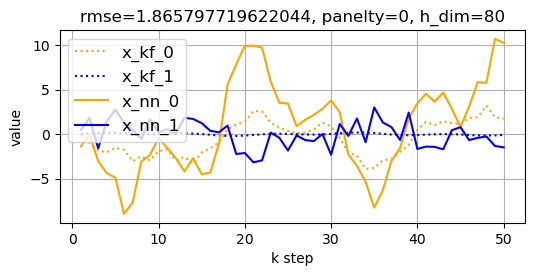

1.8554176357241925


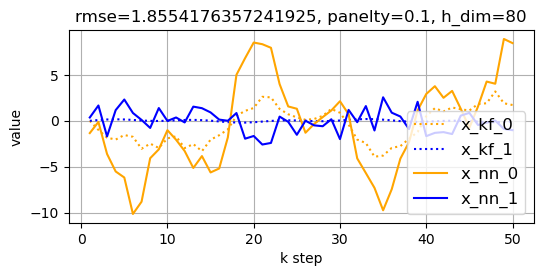

1.873431278554932


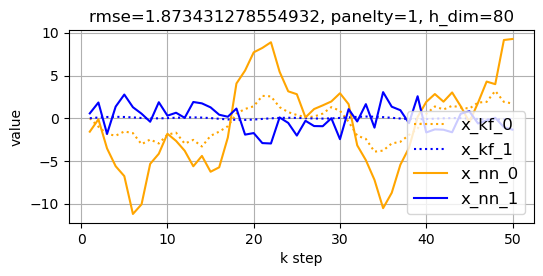

In [109]:
pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prtaexist/toy_lgssm/VAE-RNN-PHYNN_None/toy_lgssm_h80_z2_n1_mpw0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prtaexist/toy_lgssm/VAE-RNN-PHYNN_None/data/toy_lgssm_h80_z2_n1_mpw0.csv"
x_kf_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 50)
pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prtaexist/toy_lgssm/VAE-RNN-PHYNN_None/toy_lgssm_h80_z2_n1_mpw1_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prtaexist/toy_lgssm/VAE-RNN-PHYNN_None/data/toy_lgssm_h80_z2_n1_mpw1.csv"
x_kf_nn(pattern, rmse_path, panelty=0.1,h_dim=80,length = 50)
pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prtaexist/toy_lgssm/VAE-RNN-PHYNN_None/toy_lgssm_h80_z2_n1_mpw10_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prtaexist/toy_lgssm/VAE-RNN-PHYNN_None/data/toy_lgssm_h80_z2_n1_mpw10.csv"
x_kf_nn(pattern, rmse_path, panelty=1,h_dim=80,length = 50)


1.849101844299364


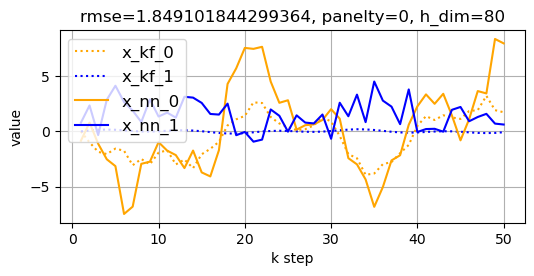

1.8738634594057195


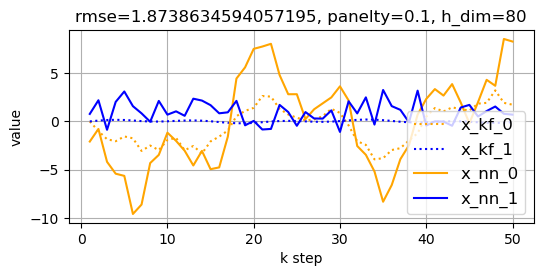

1.8548072404961096


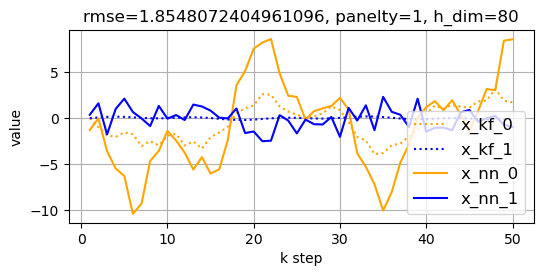

1.9147668471926105


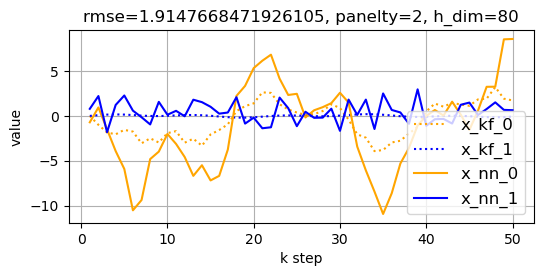

1.883512981409452


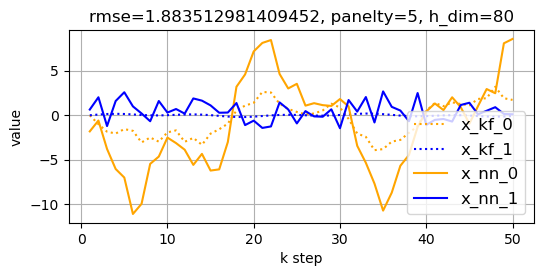

In [115]:
pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/toy_lgssm_h80_z2_n1_mpw0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/data/toy_lgssm_h80_z2_n1_mpw0.csv"
x_kf_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 50)
pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/toy_lgssm_h80_z2_n1_mpw1_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/data/toy_lgssm_h80_z2_n1_mpw1.csv"
x_kf_nn(pattern, rmse_path, panelty=0.1,h_dim=80,length = 50)
pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/toy_lgssm_h80_z2_n1_mpw10_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/data/toy_lgssm_h80_z2_n1_mpw10.csv"
x_kf_nn(pattern, rmse_path, panelty=1,h_dim=80,length = 50)
pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/toy_lgssm_h80_z2_n1_mpw20_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/data/toy_lgssm_h80_z2_n1_mpw20.csv"
x_kf_nn(pattern, rmse_path, panelty=2,h_dim=80,length = 50)
pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/toy_lgssm_h80_z2_n1_mpw50_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prta0/toy_lgssm/VAE-RNN-PHYNN_None/data/toy_lgssm_h80_z2_n1_mpw50.csv"
x_kf_nn(pattern, rmse_path, panelty=5,h_dim=80,length = 50)

2.9448060989379883


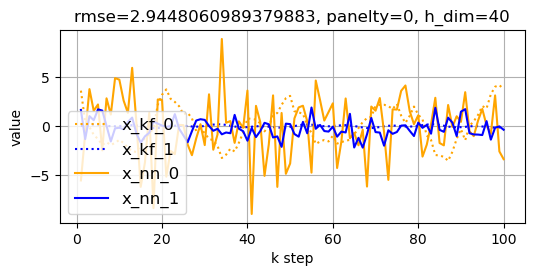

In [7]:


pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prtallknow/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/toy_lgssm_5_pre_h20_z2_n1_mpw10000_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prtallknow/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/data/toy_lgssm_5_pre_h20_z2_n1_mpw10000_A0_B0.csv"
x_kf_nn(pattern, rmse_path,panelty=0,h_dim=40,length = 100, start_from=300)